<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/ModelsWithAllSamples/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install optuna

In [5]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, 
                           ConfusionMatrixDisplay, roc_curve, auc, f1_score, accuracy_score,
                           precision_score, recall_score, matthews_corrcoef, make_scorer)
from scipy import stats as st
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

print(f"Dataset shape: {df.shape}")
print(f"Distribución de clases:\n{df['CLASS_LABEL'].value_counts()}")

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']

# 80 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)



print(f"Tamaños de conjuntos:")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")


Dataset shape: (10000, 49)
Distribución de clases:
CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64
Tamaños de conjuntos:
Train: 8000 (80.0%)
Test: 2000 (20.0%)


In [7]:
# Definir el pipeline fijo (el scaler no se optimiza)
def create_pipeline(n_neighbors, weights, metric, p):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric,
            p=p if metric == 'minkowski' else 2  # p solo aplica a minkowski
        ))
    ])

# Estrategia de validación
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Función objetivo para Optuna
def objective(trial):
    n_neighbors = trial.suggest_categorical('n_neighbors', [3, 5, 7, 9, 11, 15, 21])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    p = trial.suggest_categorical('p', [1, 2]) if metric == 'minkowski' else 2

    pipeline = create_pipeline(n_neighbors, weights, metric, p)

    scores = cross_val_score(
        pipeline,
        X_train, y_train,
        scoring=make_scorer(f1_score),
        cv=stratified_kfold,
        n_jobs=-1
    )
    # Guardar métricas en el trial
    trial.set_user_attr("cv_scores", scores.tolist())
    return scores.mean()

# Crear estudio y optimizar
study = optuna.create_study(direction='maximize')
print("Iniciando optimización con Optuna...")
study.optimize(objective, n_trials=50, show_progress_bar=True) 

# Resultados
print(f"\nMejores parámetros encontrados: {study.best_params}")
print(f"Mejor F1-score en CV: {study.best_value:.4f}")

best_trial = study.best_trial
scores = np.array(best_trial.user_attrs["cv_scores"])

mean_score = np.mean(scores)
sem = st.sem(scores)  # error estándar
ci = st.t.interval(0.95, len(scores)-1, loc=mean_score, scale=sem)

print(f"Accuracy promedio: {mean_score:.3f}")
print(f"SEM: {sem:.3f}")
print(f"IC 95%: ({ci[0]:.3f}, {ci[1]:.3f})")


Iniciando optimización con Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]


Mejores parámetros encontrados: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}
Mejor F1-score en CV: 0.9586
Accuracy promedio: 0.959
SEM: 0.002
IC 95%: (0.952, 0.965)


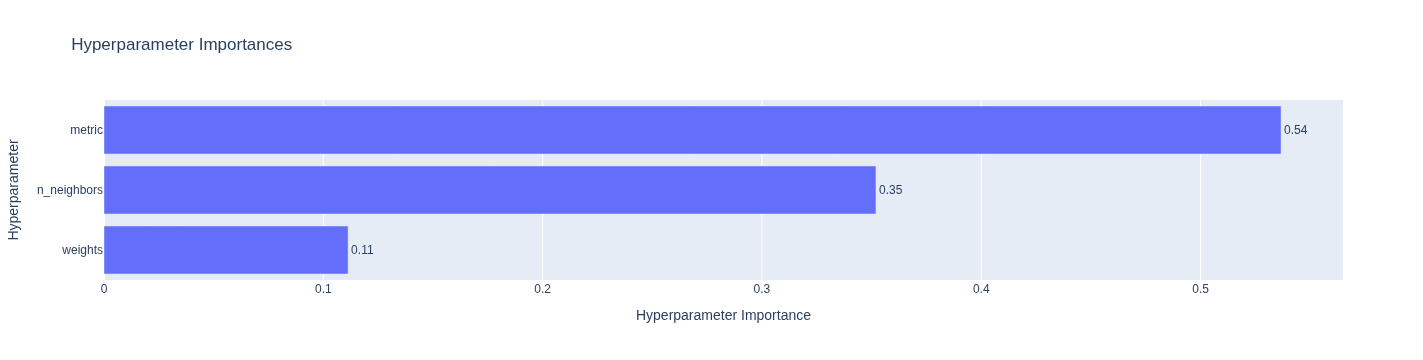

In [8]:
optuna.visualization.plot_param_importances(study)


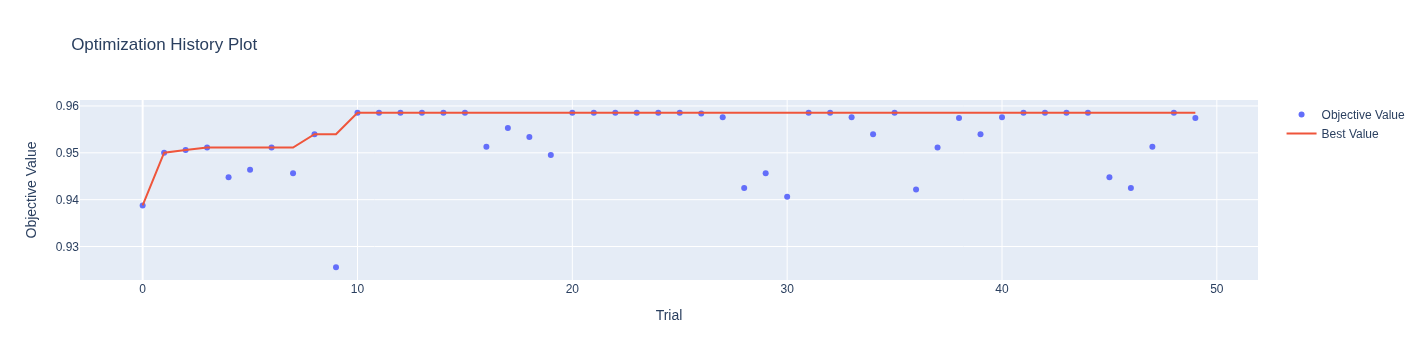

In [9]:
optuna.visualization.plot_optimization_history(study)

In [11]:
# Entrenar modelo final con mejores parámetros
best_params = study.best_params
final_pipeline = create_pipeline(
    best_params['n_neighbors'],
    best_params['weights'],
    best_params['metric'],
    best_params.get('p', 2)
)

final_pipeline.fit(X_train, y_train)
# EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA (Fase de prueba según metodología)
print("\n=== EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA ===")

# Predecir
y_test_pred = final_pipeline.predict(X_test)
y_test_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Métricas
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)


# Specificity
cm_test = confusion_matrix(y_test, y_test_pred)
test_specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])

print("Métricas en Prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall (Sensitivity): {test_recall:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc:.4f}")


print(f"\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Legítimo', 'Phishing']))




=== EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA ===
Métricas en Prueba:
Accuracy: 0.9665
Precision: 0.9542
Recall (Sensitivity): 0.9800
Specificity: 0.9530
F1-Score: 0.9669
AUC-ROC: 0.9890

Classification Report (Test):
              precision    recall  f1-score   support

    Legítimo       0.98      0.95      0.97      1000
    Phishing       0.95      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



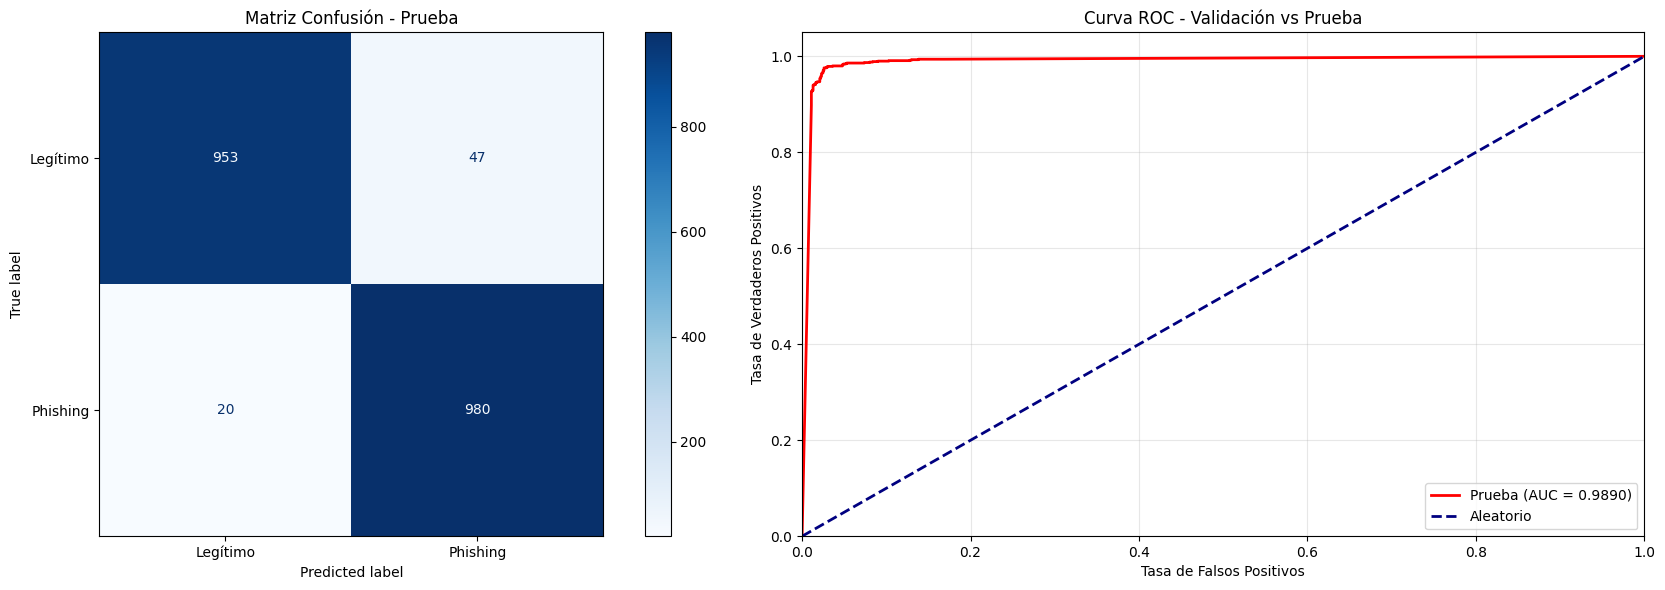

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)  # y_scores deben ser probabilidades, no clases
roc_auc = auc(fpr, tpr)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # ancho suficiente, altura reducida

# 2. Matriz de confusión - Prueba
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Legítimo', 'Phishing'])
disp_test.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriz Confusión - Prueba')

# 3. Curva ROC combinada
axes[1].plot(fpr, tpr, color='red', lw=2, label=f'Prueba (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curva ROC - Validación vs Prueba')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
